# 🏆 Predicting the NBA Finals Winner

Brayden Stach, Julian Loutzenhiser, Katherine Nunn

---

# 🛠️ Imports

team_name_home         0
game_date              0
wl_home                0
fgm_home              13
fga_home           15447
fg_pct_home        15490
fg3m_home          13218
fg3a_home          18683
fg3_pct_home       19074
ftm_home              16
fta_home            3004
ft_pct_home         3007
oreb_home          18936
dreb_home          18999
reb_home           15729
ast_home           15805
stl_home           18849
blk_home           18626
tov_home           18684
pf_home             2856
pts_home               0
plus_minus_home        0
team_name_away         0
wl_away                0
fgm_away              13
fga_away           15448
fg_pct_away        15490
fg3m_away          13219
fg3a_away          18684
fg3_pct_away       18963
ftm_away              14
fta_away            3005
ft_pct_away         3006
oreb_away          18937
dreb_away          18999
reb_away           15726
ast_away           15802
stl_away           18850
blk_away           18626
tov_away           18686


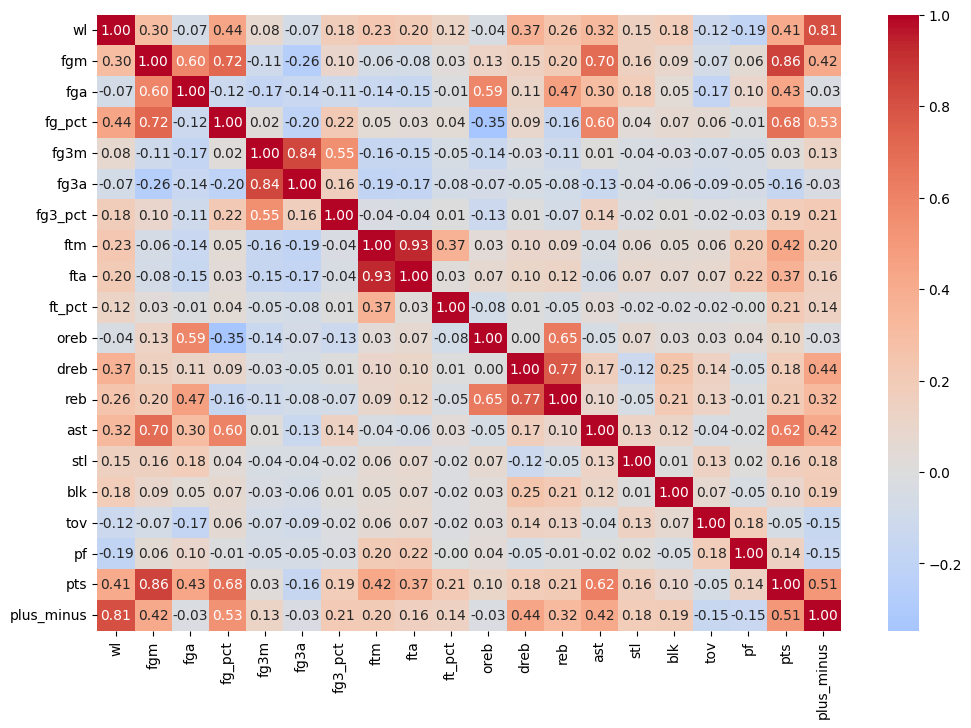

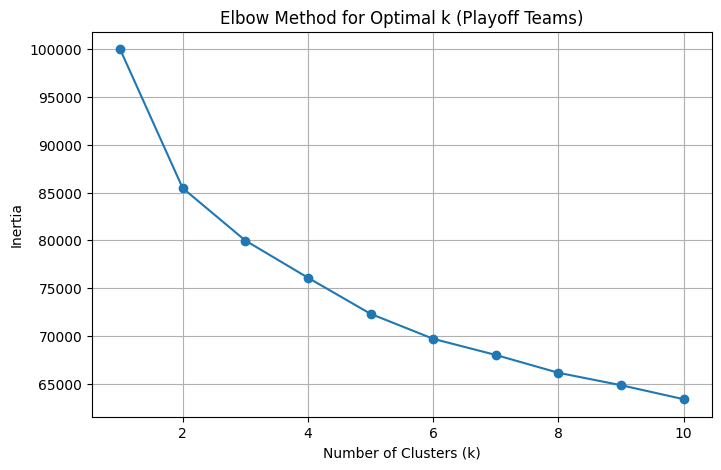

In [ ]:
%run game_stats.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

---

# 📝 Project Plan

We are going to be analyzing team data in order to come up with a power ranking of all of the basketball teams in the Playoffs. We will then compare certain matchups based on this ranking and use predictive modeling in order to predict what team is most likely to win it all.

1) 📥 Load NBA team data
2) 🧹 Clean the dataset (any empty columns / rows)
3) 🏆 Use an all around statistic such as SRS (SRS = Simple Rating System) to try to come up with a power ranking based on the regular season
4) 📈 Calculate an average of how much each team has done better / worse in the playoffs over the last ~5 years
5) 🧠 Integrate the % that each team does better in the playoffs with their power ranking score to come up with a playoff power ranking
6) 🥇 Compare each teams playoff power ranking against each other to predict who will win

This is a very simple plan that would be a good spot to start I believe. We will probably have to get additional data such as player data in order to make it more accurate. Ideally, we would also take into account trades that happen midway through the season looking more at the second half of games played. It might also be important to look at injuries, team age, experience in the playoffs, home court advantage, and other factors that might influence a teams ability to win.

---

# 🎯 Research Questions

**Main Research Question:**
- ➡️ Can we predict the winner of the 2025 NBA Finals based on team regular season performance from this season and historical playoff matchups from 2010-2023.

**Related Research Questions:**
1. 📈 How well does the Simple Rating System (SRS) predict playoff success compared to regular season wins alone?
2. 🏀 If we are required to add player data in order to do the Main Research Question, an additional bonus fun question to answer would be who deserves the MVP award this season based on stats?
3. 🛡️⚡ Is offensive or defensive rating more important in predicting playoff performance?
4. 📅🏆 Do regular season records reliably predict Finals winners?
5. 🏃‍♂️💨 Do high-tempo teams (e.g., high possessions/game) have a better shot at the Finals?
6. 🔍🏆 Has the profile of a Finals-winning team changed over the years?
7. 👑 Who is the closest player in NBA history to Lebron James (The Goat).

---

# 📊 Data Description

Our [dataset](https://www.basketball-reference.com/leagues/NBA_2025.html) contains information about NBA teams' performance during the 2024-2025 regular season.  
It includes 31 columns and one row per team. 

The key features are:

| Column Name   | Description |
|---------------|-------------|
| Rk            | Unique ID |
| Team          | Name of the NBA team |
| Age           | Average age of players on the team |
| W             | Total wins during the regular season |
| L             | Total losses during the regular season |
| PW            | Pythagorean wins (estimated wins based on points scored and allowed) |
| PL            | Pythagorean losses |
| MOV           | Margin of victory (average point differential per game) |
| SOS           | Strength of schedule (relative difficulty of opponents), 0 is average, the larger the number the tougher the schedule |
| SRS           | Simple Rating System (MOV adjusted for SOS — a measure of overall team strength), very good all-in-one statistic |
| ORtg          | Offensive Rating (points scored per 100 possessions) |
| DRtg          | Defensive Rating (points allowed per 100 possessions) |
| NRtg          | Net Rating (Offensive Rating - Defensive Rating, overall team efficiency) |
| Pace          | Number of possessions per 48 minutes (how fast the team plays) |
| FTr           | Free Throw Rate (ratio of free throws to field goal attempts) |
| 3PAr          | Three-Point Attempt Rate (percentage of shots that are three-pointers) |
| TS%           | True Shooting Percentage (adjusted shooting efficiency including free throws and threes) |
| **Offensive Four Factors** |  |
| eFG%          | Effective field goal percentage (adjusted for 3-pointers being worth more) |
| TOV%          | Turnover percentage (percentage of possessions ending in a turnover) |
| ORB%          | Offensive rebounding percentage (offensive rebounds per available opportunity) |
| FT/FGA        | Free throws per field goal attempt |
| **Defensive Four Factors** |  |
| eFG%.1        | Opponent effective field goal percentage |
| TOV%.1        | Opponent turnover percentage |
| DRB%          | Defensive rebounding percentage (defensive rebounds per available opportunity) |
| FT/FGA.1      | Opponent free throws per field goal attempt |



---

**General Observations:**
- 🛠️ There are a few unnamed columns (`Unnamed: 22`, `Unnamed: 27`) that appear to contain only missing values (NaN) and may need to be dropped.
- 🏟️ Columns related to attendance and arenas (`Arena`, `Attend.`, `Attend./G`) may not be highly relevant to predicting playoff outcomes and could also be dropped during cleaning. On top of this we could also look to drop a few other columns if we end up not using them (because SRS is a combined metric that does a lot of the work for us).
- 📈 Important metrics for our project include **SRS**, **MOV**, and **SOS**, which relate directly to team strength and game performance.


In [ ]:
# Load the data
teamdata = pd.read_csv('teamdata.csv', skiprows=1)

# Drop the league average row
teamdata = teamdata[teamdata['Team'] != 'League Average']

# Reset the index after dropping
teamdata = teamdata.reset_index(drop=True)

# Now safe to work with
teamdata.head(32)

---

# 🧹 Clean the Data

In [ ]:
# 1. Drop 'Unnamed' columns
teamdata = teamdata.drop(columns=[col for col in teamdata.columns if 'Unnamed' in col])

# 2. Drop 'Arena', 'Attend.', and 'Attend./G' columns
teamdata = teamdata.drop(columns=['Arena', 'Attend.', 'Attend./G'])

# 3. Double-check missing values after dropping
print(teamdata.isnull().sum())

# 4. Confirm data types
print(teamdata.dtypes)

---

# 🏆 Build Power Ranking

In [8]:
# 1. Sort teams by SRS (Simple Rating System) in descending order
power_ranking = teamdata.sort_values(by='SRS▼', ascending=False).reset_index(drop=True)


# 2. Display the top teams
power_ranking[['Team', 'SRS▼']]

,Team,SRS▼
0,Oklahoma City Thunder*,12.70
1,Cleveland Cavaliers*,8.81
2,Boston Celtics*,8.28
3,Minnesota Timberwolves*,5.15
4,Houston Rockets*,4.97
5,Los Angeles Clippers*,4.84
6,Memphis Grizzlies*,4.79
7,Denver Nuggets*,3.97
8,New York Knicks*,3.59
9,Golden State Warriors*,3.56


In [9]:
playoff_teams = [
    'Oklahoma City Thunder', 'Memphis Grizzlies', 'Denver Nuggets', 'Los Angeles Clippers',
    'Los Angeles Lakers', 'Minnesota Timberwolves', 'Houston Rockets', 'Golden State Warriors',
    'Cleveland Cavaliers', 'Miami Heat', 'Indiana Pacers', 'Milwaukee Bucks',
    'New York Knicks', 'Detroit Pistons', 'Boston Celtics', 'Orlando Magic'
]

# Remove '*' from the team names first
teamdata['Team'] = teamdata['Team'].str.replace('*', '', regex=False).str.strip()

# Now filter only playoff teams
teamdata_playoffs = teamdata[teamdata['Team'].isin(playoff_teams)].reset_index(drop=True)

# Quick check
print(teamdata_playoffs[['Team', 'SRS▼']])

                      Team   SRS▼
0    Oklahoma City Thunder  12.70
1      Cleveland Cavaliers   8.81
2           Boston Celtics   8.28
3   Minnesota Timberwolves   5.15
4          Houston Rockets   4.97
5     Los Angeles Clippers   4.84
6        Memphis Grizzlies   4.79
7           Denver Nuggets   3.97
8          New York Knicks   3.59
9    Golden State Warriors   3.56
10         Milwaukee Bucks   2.12
11         Detroit Pistons   1.73
12          Indiana Pacers   1.68
13      Los Angeles Lakers   1.45
14              Miami Heat   0.11
15           Orlando Magic  -0.70


These are all of the playoff teams listed. Historically, the team that has won the finals has almost always been in the top 5 of SRS ratings in the regular season.

---

# 📚 K-Means Clustering

We can use K-Means clustering in order to find out how similar each playoff team is to each other. We can come up with distinct groupings to better understand which team actually has a chance at winning the championship. We could order these groupings something like the favorites and then just the contenders.

---

# 🧹 Drop Categorical Columns and Scale Features

In [10]:
# Keep only numeric columns
teamdata_playoffs_numeric = teamdata_playoffs.select_dtypes(include=['float64', 'int64'])

# Save feature names
feature_names = teamdata_playoffs_numeric.columns

# Scale the numeric features
scaler = StandardScaler()
teamdata_playoffs_scaled = scaler.fit_transform(teamdata_playoffs_numeric)

We use StandardScaler so that each feature has a mean of 0 and a standard deviation of 1. If we didn't scale the data then some features with a larger absolute value would dominate the others which is not what we want. 

---

# 📊 Find the Optimal Number of Clusters (Elbow Method)

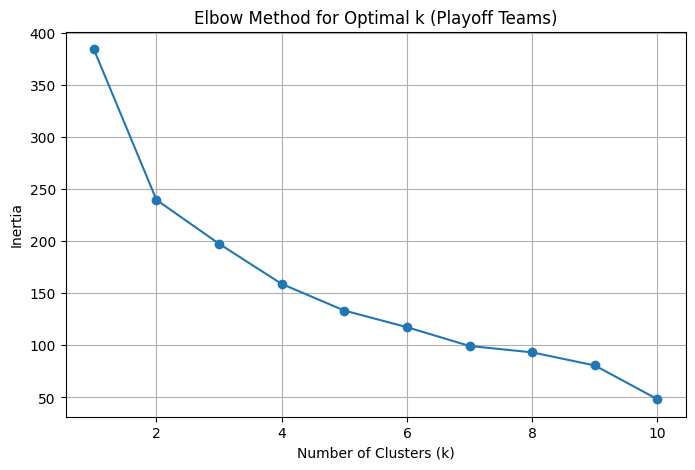

In [11]:
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(teamdata_playoffs_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k (Playoff Teams)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

From the elbow method we can see that the decrease starts to level out at around 2 clusters.

---

# 📊 Find the Optimal Number of Clusters (Silhouette Method)

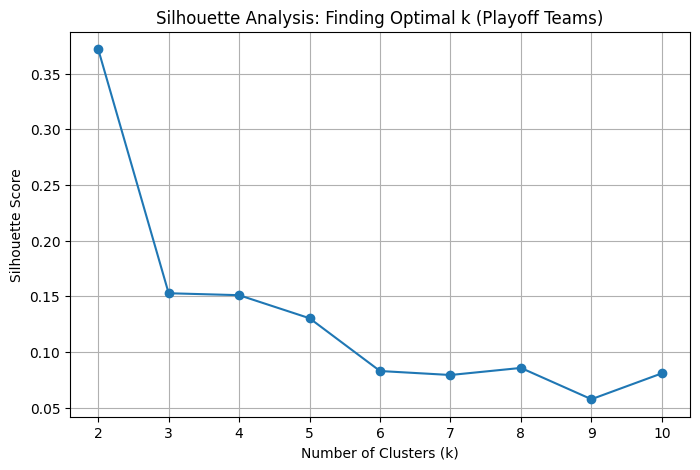

In [12]:
# Range of k values (must start at 2 because silhouette needs at least 2 clusters)
k_range = range(2, 11)

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(teamdata_playoffs_scaled)
    score = silhouette_score(teamdata_playoffs_scaled, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8,5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis: Finding Optimal k (Playoff Teams)')
plt.grid(True)
plt.show()

The silhouette method strongly suggests that we should only use two clusters as well.

---

# 🛠️ Apply K-Means Clustering with k=2

In [13]:
# Apply KMeans clustering with k=2
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
teamdata_playoffs['Cluster'] = kmeans.fit_predict(teamdata_playoffs_scaled)

# Preview the playoff teams with their cluster assignments
teamdata_playoffs[['Team', 'Cluster']].head()

,Team,Cluster
0,Oklahoma City Thunder,0
1,Cleveland Cavaliers,0
2,Boston Celtics,0
3,Minnesota Timberwolves,1
4,Houston Rockets,1


---

# 📋 Find Averages Among Clusters

In [14]:
# Get the cluster centers in scaled units
centroids_scaled = kmeans.cluster_centers_

# Inverse transform to get original units (undo scaling)
centroids_unscaled = scaler.inverse_transform(centroids_scaled)

# Create a DataFrame to show each cluster's average feature values
centroids_df = pd.DataFrame(
    centroids_unscaled, 
    columns=feature_names
)

# Rename the index to make it pretty
centroids_df.index = [f"Cluster {i}" for i in range(k)]

centroids_df

,Rk,Age,W,L,PW,PL,MOV,SOS,SRS▼,ORtg,...,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1
Cluster 0,2.000000,26.766667,64.333333,17.666667,64.000000,18.000000,10.506667,-0.573333,9.930000,120.866667,...,0.470667,0.597000,0.566333,10.900000,25.266667,0.178667,0.521000,13.033333,75.133333,0.182000
Cluster 1,10.153846,26.930769,47.538462,34.461538,48.153846,33.846154,2.967692,-0.103077,2.866154,115.715385,...,0.409385,0.582308,0.549077,12.538462,25.253846,0.194615,0.538385,12.969231,75.569231,0.186923


This lets us see the average statistics of each cluster and what each cluster is being grouped by.

---

# 🎨 Visualize the Clusters using PCA

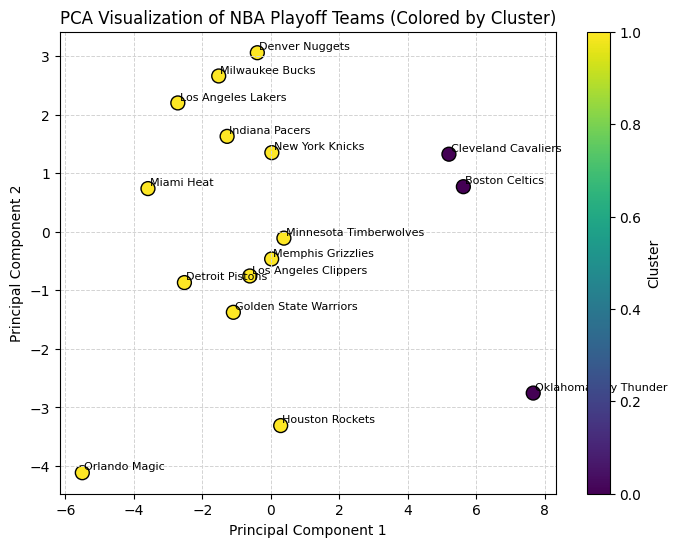

In [15]:
# Reduce dimensions to 2 principal components for visualization
pca = PCA(n_components=2)
teamdata_playoffs_pca = pca.fit_transform(teamdata_playoffs_scaled)

# Create a scatter plot of the clusters
plt.figure(figsize=(8,6))
plt.scatter(
    teamdata_playoffs_pca[:,0], 
    teamdata_playoffs_pca[:,1], 
    c=teamdata_playoffs['Cluster'], 
    cmap='viridis', 
    s=100, 
    edgecolor='k'
)
for i, team in enumerate(teamdata_playoffs['Team']):
    plt.text(
        teamdata_playoffs_pca[i,0]+0.05, 
        teamdata_playoffs_pca[i,1]+0.05, 
        team, 
        fontsize=8
    )
plt.title('PCA Visualization of NBA Playoff Teams (Colored by Cluster)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, color='lightgray', linestyle='--', linewidth=0.7)
plt.colorbar(label='Cluster')
plt.show()

This visualization shows that the Cavs, Celtics, and Thunder are the 3 statistical anomalies in this dataset. This does make sense because these 3 teams were by a pretty wide margin the best performers in the regular season.

---

# 🧠 What the Principal Components mean

In [16]:
# Get the PCA components
pca_components = pca.components_

# Create a DataFrame to visualize
pca_loadings = pd.DataFrame(
    pca_components.T, 
    columns=['PC1', 'PC2'], 
    index=feature_names
)

pca_loadings

,PC1,PC2
Rk,-0.267670,0.040492
Age,-0.004609,0.248290
W,0.282266,0.006377
L,-0.282266,-0.006377
PW,0.293179,-0.050846
PL,-0.293179,0.050846
MOV,0.294013,-0.052062
SOS,-0.059622,-0.105880
SRS▼,0.290505,-0.064790
ORtg,0.253246,0.220804


It seems as though PC1 is affected very heavily by Wins, Losses, SRS, Offensive Rating, Net Rating, Margin of Victory, and PL. This means that a higher PC1 = Better Team Performance. PC2 is based off of a mixture of shooting efficiency and defense but is not as clear cut as to whether higher = better as PC1 was.

---

# 🧩 Model Training 

In [45]:
# Load the NBA playoff dataset
nba_playoff_data = pd.read_csv("nba_playoff_matchups.csv")

nba_playoff_data.head(5)

,Season,Round,Team A,Team B,Team A SRS,Team B SRS,Team A ORtg,Team B ORtg,Team A DRtg,Team B DRtg,Winner
0,2010,First Round,Cleveland Cavaliers,Chicago Bulls,6.1,-1.5,112.4,105.0,104.5,107.8,Cleveland Cavaliers
1,2010,First Round,Orlando Magic,Charlotte Bobcats,5.8,1.2,111.5,103.2,102.1,100.5,Orlando Magic
2,2010,First Round,Atlanta Hawks,Milwaukee Bucks,3.5,0.9,109.8,104.9,106.2,105.3,Atlanta Hawks
3,2010,First Round,Boston Celtics,Miami Heat,2.7,1.0,110.2,106.5,105.4,104.7,Boston Celtics
4,2010,First Round,Los Angeles Lakers,Oklahoma City Thunder,6.3,3.1,112.8,110.3,104.0,106.2,Los Angeles Lakers


This dataset has all of the matchups from every playoff game from 2010-2023 with their SRS (Simple Rating System) that calculates a teams strength based on their average margin of victory (how many points they win by) combined with their strength of schedule (how strong are the teams they play). It also includes each teams ORtg (Offensive Rating) and DRtg (Defensive Rating). The Offensive Rating is the average amount of points a team scores per 100 possessions, higher is better. The Defensive Rating is the average amount of points a team allows per 100 possessions, lower is better. It also includes the season year, round of the playoffs, the teams that played against each other, and the winner. We chose SRS, ORtg, and DRtg as the first 3 metrics to base our model off of because they are all very good predictors as to how good a team is. We might factor in more metrics later to improve accuracy of the model. 

In [46]:
# Identify rows where Team B has higher SRS
mask = nba_playoff_data["Team A SRS"] < nba_playoff_data["Team B SRS"]

# Swap stat columns
cols_to_swap = ["SRS", "ORtg", "DRtg"]
for col in cols_to_swap:
    a_col = f"Team A {col}"
    b_col = f"Team B {col}"
    nba_playoff_data.loc[mask, a_col], nba_playoff_data.loc[mask, b_col] = (
        nba_playoff_data.loc[mask, b_col].values,
        nba_playoff_data.loc[mask, a_col].values
    )

# Swap team names
nba_playoff_data.loc[mask, "Team A"], nba_playoff_data.loc[mask, "Team B"] = (
    nba_playoff_data.loc[mask, "Team B"].values,
    nba_playoff_data.loc[mask, "Team A"].values
)

This is the standardization step. We identify which team is the stronger team by SRS values and then we swap SRS, ORtg, DRtg using the cols_to_swap variable and the for loop. Then the team names are swapped, using the nba_playoff_data. This makes it so that the stronger team is always Team A, which makes the model easier to learn from and reduces unnecessary variance in the data. 

In [47]:
nba_playoff_data["TeamA_Win"] = (nba_playoff_data["Winner"] == nba_playoff_data["Team A"]).astype(int)

This step is to assign the value 1 if Team A wins and the value 0 if Team B wins.

In [48]:
# Recalculate labels and features
nba_playoff_data["SRS_Diff"] = nba_playoff_data["Team A SRS"] - nba_playoff_data["Team B SRS"]
nba_playoff_data["ORtg_Diff"] = nba_playoff_data["Team A ORtg"] - nba_playoff_data["Team B ORtg"]
nba_playoff_data["DRtg_Diff"] = nba_playoff_data["Team B DRtg"] - nba_playoff_data["Team A DRtg"]  # Lower DRtg = better defense

Because the data spans multiple seasons (2010–2023), the average values of metrics like SRS and ORtg can vary from year to year due to changes in league pace, rules, or offensive style. By using relative differences (Team A minus Team B), we remove season-level variance and instead focus on how teams compare to each other in each matchup. We are trying to analyze the factors that affect a teams chance of winning, not how these factors change from season to season as the season variance will alter the model and is irrelevant to the overall outcome of the model.

In [49]:
# Train the model
features = nba_playoff_data[["SRS_Diff", "ORtg_Diff", "DRtg_Diff"]]
target = nba_playoff_data["TeamA_Win"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

We selected the features we want to train the model on which is the differences we calculated earlier. We then select the target label and split the dataset to 80% for training and 20% for testing. We then train the XGBoost classifier. XGBoost builds a lot of decision trees and then combine them to make very strong predictions. Since it uses trees it doesn't care about the absolute scale of the numbers it just cares about the best split point. For example "Is SRS_Diff > 3.7? -> Go left or right".

In [22]:
# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6428571428571429


We test the model on the 20% of data we split at the start. We do this to evaluate the models performance. A 65% accuracy is not bad considering we only trained it on 3 metrics. Those 3 metrics being the SRS, the offesnisve rating and the defensive rating.

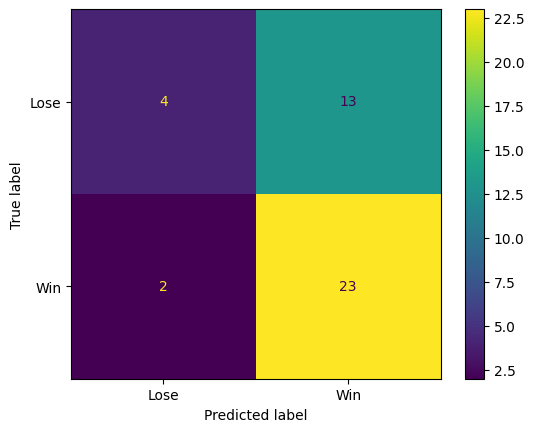

In [25]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Lose", "Win"]).plot()

Based on this matrix it seems like this model is biased on predicting a win. 

In [26]:
print(classification_report(y_test, y_pred, target_names=["Lose", "Win"]))

              precision    recall  f1-score   support

        Lose       0.67      0.24      0.35        17
         Win       0.64      0.92      0.75        25

    accuracy                           0.64        42
   macro avg       0.65      0.58      0.55        42
weighted avg       0.65      0.64      0.59        42



This provides more proof that the model is way too biased in predicting a win, the f1-score for a loss is 35% and the f1-score for a win is 75%. Maybe we do not have enough features yet?

---

# 🧮 Matchup Probability Function

In [27]:
def predict_matchup_probability(team1, team2, team_stats_df, model):
    # Lookup stats for both teams
    row1 = team_stats_df[team_stats_df["Team"] == team1].iloc[0]
    row2 = team_stats_df[team_stats_df["Team"] == team2].iloc[0]

    # Determine which team is "better" (higher SRS)
    if row1["SRS▼"] >= row2["SRS▼"]:
        better_team, worse_team = row1, row2
        better_name, worse_name = team1, team2
    else:
        better_team, worse_team = row2, row1
        better_name, worse_name = team2, team1

    # Compute feature differences with better team as Team A
    srs_diff = better_team["SRS▼"] - worse_team["SRS▼"]
    ortg_diff = better_team["ORtg"] - worse_team["ORtg"]
    drtg_diff = worse_team["DRtg"] - better_team["DRtg"]  # Lower DRtg = better defense

    # Prepare input features
    features = pd.DataFrame({
        "SRS_Diff": [srs_diff],
        "ORtg_Diff": [ortg_diff],
        "DRtg_Diff": [drtg_diff]
    })

    # Predict probability that the better team (Team A) wins
    prob_better_team_wins = model.predict_proba(features)[0][1]

    # Return a detailed result
    return {
        "better_team": better_name,
        "worse_team": worse_name,
        "win_probability": prob_better_team_wins
    }


This is a function that is used to predict each matchup that is in the playoffs. This function takes in two NBA teams, a DataFrame of team statistics, and the trained XGBoost model. It starts by extracting the season stats for the two teams (from the original dataset for the 2024-2025 season), then it compares the SRS values and assigns the one with the higher SRS value "better_team". We then compute the differences in the 3 metrics and prepare them as input features into the model. Finally, we predict the probability that the better team will win and then return a dictionary with the results.

In [28]:
first_round_matchups = [
    # West
    ("Oklahoma City Thunder", "Memphis Grizzlies"),
    ("Los Angeles Lakers", "Minnesota Timberwolves"),
    ("Denver Nuggets", "Los Angeles Clippers"),
    ("Houston Rockets", "Golden State Warriors"),
    
    # East
    ("Cleveland Cavaliers", "Miami Heat"),
    ("Indiana Pacers", "Milwaukee Bucks"),
    ("Boston Celtics", "Orlando Magic"),
    ("Detroit Pistons", "New York Knicks")
]

for team_a, team_b in first_round_matchups:
    result = predict_matchup_probability(team_a, team_b, teamdata_playoffs, model)
    print(f"{result['better_team']} vs {result['worse_team']} → {result['better_team']} win probability: {result['win_probability']:.2%}, {result['worse_team']}: {1 - result['win_probability']:.2%}")

Oklahoma City Thunder vs Memphis Grizzlies → Oklahoma City Thunder win probability: 98.80%, Memphis Grizzlies: 1.20%
Minnesota Timberwolves vs Los Angeles Lakers → Minnesota Timberwolves win probability: 61.56%, Los Angeles Lakers: 38.44%
Los Angeles Clippers vs Denver Nuggets → Los Angeles Clippers win probability: 88.99%, Denver Nuggets: 11.01%
Houston Rockets vs Golden State Warriors → Houston Rockets win probability: 27.60%, Golden State Warriors: 72.40%
Cleveland Cavaliers vs Miami Heat → Cleveland Cavaliers win probability: 82.17%, Miami Heat: 17.83%
Milwaukee Bucks vs Indiana Pacers → Milwaukee Bucks win probability: 16.08%, Indiana Pacers: 83.92%
Boston Celtics vs Orlando Magic → Boston Celtics win probability: 97.47%, Orlando Magic: 2.53%
New York Knicks vs Detroit Pistons → New York Knicks win probability: 98.76%, Detroit Pistons: 1.24%


We specify in a list of tuples, each playoff series for the first round of the playoffs in 2025. The matchups are split between the East and the West and we iterate through each matchup and call the predict_matchup_probability function for each one and then print them out.

These percentages seem fairly accurate but it is impossible to take into account every single factor such as injuries, playoff overperformers/underperformers and other factors like home court advantage. One notable upset that already happened based on these predictions are the Nuggets beating the Clippers. This shows the unpredictability of sports games which is one of the many reasons why they are so entertaining.

---

# 🔁 Simulation Functions

In [29]:
# Function to simulate a series based on win probability of better team
def simulate_series(team_a, team_b, team_stats_df, model):
    result = predict_matchup_probability(team_a, team_b, team_stats_df, model)
    win_prob = result["win_probability"]
    winner = result["better_team"] if np.random.rand() < win_prob else result["worse_team"]
    return winner

This function predicts the win probability using the predict_matchup_probability function. It uses the np.random.rand() to turn the decimal probability into a percentage and then returns the winner for that series. 

In [30]:
# Full playoff simulation function
def simulate_full_playoffs(team_stats_df, model, n_simulations=1000):
    championship_counts = defaultdict(int)

    for _ in range(n_simulations):
        # Round 1
        r1_matchups = [
            ("Oklahoma City Thunder", "Memphis Grizzlies"),
            ("Los Angeles Lakers", "Minnesota Timberwolves"),
            ("Denver Nuggets", "Los Angeles Clippers"),
            ("Houston Rockets", "Golden State Warriors"),
            ("Cleveland Cavaliers", "Miami Heat"),
            ("Indiana Pacers", "Milwaukee Bucks"),
            ("Boston Celtics", "Orlando Magic"),
            ("Detroit Pistons", "New York Knicks"),
        ]
        r1_winners = [simulate_series(a, b, team_stats_df, model) for a, b in r1_matchups]

        # Round 2
        r2_matchups = [
            (r1_winners[0], r1_winners[1]),  # West semifinals
            (r1_winners[2], r1_winners[3]),
            (r1_winners[4], r1_winners[5]),  # East semifinals
            (r1_winners[6], r1_winners[7])
        ]
        r2_winners = [simulate_series(a, b, team_stats_df, model) for a, b in r2_matchups]

        # Conference Finals
        west_final = simulate_series(r2_winners[0], r2_winners[1], team_stats_df, model)
        east_final = simulate_series(r2_winners[2], r2_winners[3], team_stats_df, model)

        # NBA Finals
        champion = simulate_series(west_final, east_final, team_stats_df, model)
        championship_counts[champion] += 1

    return championship_counts

This function runs a simulations of the 2025 playoffs and predicts who will win the championship. It simulates the first round of the playoffs which has 8 series and then it takes the winners of these series and simulates the second round which has 4 series. Then it repeats this until the finals and increments the winning teams championship count.

In [ ]:
# Run the simulation
results = simulate_full_playoffs(teamdata_playoffs, model, n_simulations=1000)

# Convert to DataFrame for display
results_df = pd.DataFrame(list(results.items()), columns=["Team", "Championships"])
results_df["Win %"] = results_df["Championships"] / 1000 * 100
results_df.sort_values("Win %", ascending=False, inplace=True)

# Display results
print("🏆 NBA Finals Probabilities (Monte Carlo Simulation, 1000 runs)")
print(results_df.to_string(index=False))

We then run the simulation function 1000 times and then display the results. Based on this simulation simulating 1,000 playoff matchups brackets, it seems that OKC is the overwhelming favorite to win the title this year. Cavs and Celtics are the favorites from the East but OKC had a very historic regular season so it makes sense that they are the favorites.

---

# 🧩 More Accurate Model Training

Our previous model was decent, it was fairly accurate but it had a lot of False Positives. This might be because of the limited attributes it is analyzing so I went through and made a csv file with a lot more attributes that we can analyze and hopefully get a higher accuracy.

In [ ]:
# Load the NBA playoff dataset
nba_playoff_data_adv = pd.read_csv("NBA_Full_Playoff_Matchups_Stats.csv")

nba_playoff_data_adv.head(5)

There are now a lot more than just the 3 statistics from each team in every playoff matchup. If you are wondering what any of these statistics mean they are defined at the start of my notebook.